## Build and Train

In [4]:
import tensorflow as tf
from boltzmann.data.mnist import load_mnist
from boltzmann.restricted.base import train
from boltzmann.restricted.bernoulli import GlorotInitializer
from boltzmann.restricted.bernoulli.dense import (
    DenseBernoulliRBM, init_fantasy_latent, LogInternalInformation)

image_size = (16, 16)
(X, y), _ = load_mnist(image_size=image_size, binarize=True,
                       minval=0, maxval=1)

ambient_size = image_size[0] * image_size[1]
latent_size = 256
sparsity = 0.8
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(10000).repeat(10).batch(batch_size)
rbm = DenseBernoulliRBM(ambient_size, latent_size, GlorotInitializer(X),
                        sparsity=sparsity)
fantasy_latent = init_fantasy_latent(rbm, batch_size)
optimizer = tf.optimizers.Adam()
callbacks = [LogInternalInformation(rbm, log_step=10, verbose=True)]
fantasy_latent = train(rbm, optimizer, dataset, fantasy_latent,
                       callbacks=callbacks)

) - latent bias: 0.05818 (0.22572)
step: 3760 - mean energy: -102.35832 - recon error: 0.05814 - latent-on ratio: 0.41193 - mean free energy: -161.67780 - kernel: -0.00863 (0.14020) - ambient bias: -6.00433 (6.24735) - latent bias: 0.05770 (0.22419)
step: 3770 - mean energy: -98.80397 - recon error: 0.05670 - latent-on ratio: 0.41495 - mean free energy: -165.43433 - kernel: -0.00841 (0.14055) - ambient bias: -6.00224 (6.24866) - latent bias: 0.05684 (0.22152)
step: 3780 - mean energy: -104.87701 - recon error: 0.06042 - latent-on ratio: 0.41467 - mean free energy: -164.31656 - kernel: -0.00828 (0.14089) - ambient bias: -6.00113 (6.24920) - latent bias: 0.05672 (0.22093)
step: 3790 - mean energy: -100.49699 - recon error: 0.05588 - latent-on ratio: 0.41782 - mean free energy: -164.88593 - kernel: -0.00835 (0.14115) - ambient bias: -6.00152 (6.24893) - latent bias: 0.05720 (0.22245)
step: 3800 - mean energy: -101.48358 - recon error: 0.05811 - latent-on ratio: 0.40976 - mean free energy:

## Visualize the Latent

In [5]:
from sklearn.manifold import TSNE
from boltzmann.restricted.base import relax, RestrictedBoltzmannMachine

def get_relaxed_latent_projection(
        rbm: RestrictedBoltzmannMachine,
        ambient: tf.Tensor,
        max_iter: int = 10,
        tol: float = 1e-8):
    relaxed_ambient, _ = relax(rbm, ambient, max_iter, tol)
    relaxed_latent = rbm.get_latent_given_ambient(relaxed_ambient).prob_argmax
    projection = TSNE().fit_transform(relaxed_latent)
    return projection

In [6]:
import numpy as np
import matplotlib.pyplot as plt

labels = {1, 2, 3, 4}
X_in_labels, y_in_labels = [], []
for xi, yi in zip(X, y):
    yi = np.argmax(yi)  # y is one-hot encoded.
    if yi in labels:
        X_in_labels.append(xi)
        y_in_labels.append(yi)
    if len(X_in_labels) == 1000:
      break

Z = get_relaxed_latent_projection(rbm, np.array(X_in_labels))

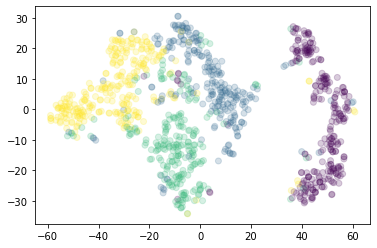

In [7]:
plt.scatter(Z[:, 0], Z[:, 1], c=y_in_labels, alpha=0.2)
plt.show()

## Try Pruning

In [8]:
def get_recon_error(rbm, real_ambient):
    real_latent = rbm.get_latent_given_ambient(real_ambient).prob_argmax
    recon_ambient = rbm.get_ambient_given_latent(real_latent).prob_argmax
    recon_error = tf.reduce_mean(
        tf.cast(recon_ambient != real_ambient, 'float32'))
    return recon_error

13214
tf.Tensor(0.051492188, shape=(), dtype=float32)


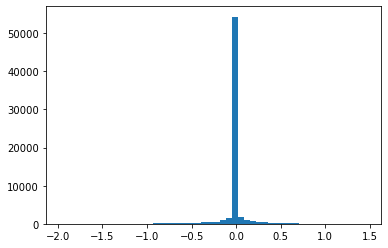

In [9]:
original_kernel = rbm.kernel.numpy()
plt.hist(original_kernel.reshape([-1]), bins=50)
plt.plot()

print(np.sum(np.where(np.abs(original_kernel) < 1e-8, 0, 1)))
print(get_recon_error(rbm, X[:1000]))

5348
tf.Tensor(0.048140626, shape=(), dtype=float32)


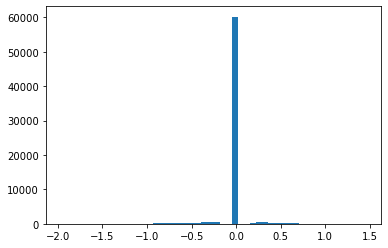

In [10]:
pruned_kernel = np.where(np.abs(original_kernel) < 0.2, 0., original_kernel)
plt.hist(pruned_kernel.reshape([-1]), bins=50)
plt.plot()

rbm._kernel.assign(pruned_kernel)
print(np.sum(np.where(np.abs(pruned_kernel) < 1e-8, 0, 1)))
print(get_recon_error(rbm, X[:1000]))
_ = rbm._kernel.assign(original_kernel)